In [16]:
import pandas as pd
import glob
import os
import seaborn as sns
# import keras.applications.efficientnet as efc
from keras.applications import *
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from tqdm import tqdm

IMG_SIZE = 224
mushroom = pd.read_csv('csv/labeled.csv')

In [3]:
# Load the class labels from the file
with open('labels/names.txt', 'r') as file:
    class_labels = file.read().splitlines()
with open('labels/yes.txt', 'r') as file:
    yes_labels = file.read().splitlines()
with open('labels/maybe.txt', 'r') as file:
    maybe_labels = file.read().splitlines()
with open('labels/no.txt', 'r') as file:
    no_labels = file.read().splitlines()

In [ ]:
df = pd.read_csv('csv/MO MI images - imagesAndNames.csv')
df.index.name = 'index'

In [11]:
jpgFilenamesList = glob.glob('./data/*.jpg')

photos = []
for i in jpgFilenamesList:
    photos.append(int((os.path.basename(i))[:-4]))

df_exist_photos = df[df.index.isin(photos)]

families = df_exist_photos['name'].str.split(n=1).str[0].value_counts()[:1000]

families

Amount of unique classes: 543


Russula            1382
Amanita             720
Cortinarius         430
Lactarius           363
Tricholoma          293
                   ... 
Annulohypoxylon       1
Bridgeoporus          1
Hexagonia             1
Loweomyces            1
Bilimbia              1
Name: name, Length: 543, dtype: int64

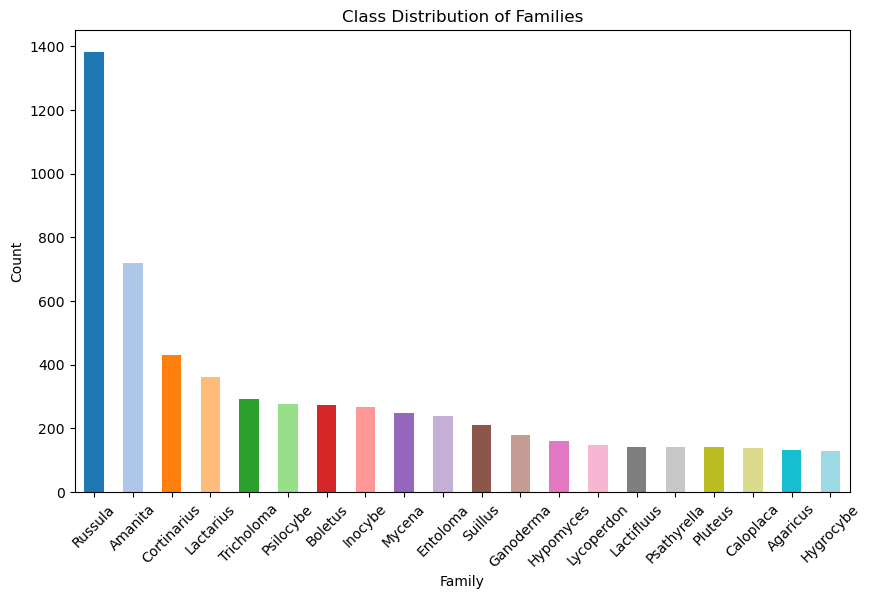

In [34]:
families_distr = families.head(20)
colors = sns.color_palette('tab20', len(families))

plt.figure(figsize=(10, 6))
families_distr.plot(kind='bar', color=colors)
plt.xlabel('Family')
plt.ylabel('Count')
plt.title('Class Distribution of Families')
plt.xticks(rotation=45)
plt.savefig('img/dist.png')
plt.show()

In [ ]:
top = df_exist_photos[df_exist_photos.name.isin(families.index)]

top= top.rename_axis('index').reset_index()
top = top[['index', 'name']]
top.dropna(inplace=True)

top

,index,name
0,210014,Lactarius
1,210015,Lactarius
2,210016,Lactarius
3,210017,Lactarius
4,210043,Sclerotinia
...,...,...
2024,224901,Tricholoma
2025,224972,Flammulina
2026,224973,Flammulina
2027,224998,Tricholoma


In [ ]:
# Split dataset into train and test

train, test = train_test_split(top, test_size=0.3, shuffle=True, random_state=42)

print(f"dataset size: {top.size}")
print(f"train data size: {train.size}")
print(f"test data size: {test.size}")

dataset size: 4058
train data size: 2840
test data size: 1218


In [ ]:
# Copy train and test images in different directories
# with class names

TRAIN_DIR = 'data_train'
TEST_DIR = 'data_test'

for family in tqdm(families.index):

# for family in tqdm(families):

    if not os.path.exists(TRAIN_DIR):
        os.makedirs(TRAIN_DIR)
    if not os.path.exists(TEST_DIR):
        os.makedirs(TEST_DIR)
    
    os.makedirs(f"{TRAIN_DIR}/{family}")
    os.makedirs(f"{TEST_DIR}/{family}")

    # Copy train images
    for idx, row in train[train['name'] == family].iterrows():
        shutil.copy(f'data/{row["index"]}.jpg', f'{TRAIN_DIR}/{family}/{row["index"]}.jpg')
    
    # Copy test images
    for idx, row in test[test['name'] == family].iterrows():       
        shutil.copy(f'data/{row["index"]}.jpg', f'{TEST_DIR}/{family}/{row["index"]}.jpg')

100%|██████████| 543/543 [00:01<00:00, 464.24it/s]


In [ ]:
! du -sh data_train
! du -sh data_test

191M	data_train
 84M	data_test


In [ ]:
def build_model(num_classes, img_size=IMG_SIZE):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="EfficientNet")
    model.compile(
        optimizer='adam', 
        loss="sparse_categorical_crossentropy", 
        metrics=["sparse_categorical_accuracy"]
    )
    
    return model

def use_keras_new(path):
    keras_ds = tf.keras.preprocessing.image_dataset_from_directory(
        path, 
        batch_size=32, 
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    # Configure the dataset for performance
    keras_ds = keras_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    num_classes = len(os.listdir(path))
    model = build_model(num_classes)

    history = model.fit(keras_ds, batch_size=32, epochs=10)
    model.save_weights('model.h5')  # Save in HDF5
    model.save('best_model')
    return model, history

# model, history = use_keras_new('data_train')

# If you want to use a pre-trained model:
loaded_model = tf.keras.models.load_model("best_model")
model = loaded_model

Found 1420 files belonging to 543 classes.
Epoch 1/10
45/45 [==============================] - 46s 944ms/step - loss: 5.3277 - sparse_categorical_accuracy: 0.1521
Epoch 2/10
45/45 [==============================] - 56s 1s/step - loss: 2.1705 - sparse_categorical_accuracy: 0.5500
Epoch 3/10
45/45 [==============================] - 74s 2s/step - loss: 1.1229 - sparse_categorical_accuracy: 0.7486
Epoch 4/10
45/45 [==============================] - 51s 1s/step - loss: 0.7150 - sparse_categorical_accuracy: 0.8415
Epoch 5/10
45/45 [==============================] - 44s 977ms/step - loss: 0.5146 - sparse_categorical_accuracy: 0.8817
Epoch 6/10
45/45 [==============================] - 53s 1s/step - loss: 0.3782 - sparse_categorical_accuracy: 0.9190
Epoch 7/10
45/45 [==============================] - 46s 1s/step - loss: 0.3223 - sparse_categorical_accuracy: 0.9317
Epoch 8/10
45/45 [==============================] - 49s 1s/step - loss: 0.2508 - sparse_categorical_accuracy: 0.9472
Epoch 9/10
45/4

INFO:tensorflow:Assets written to: best_model/assets


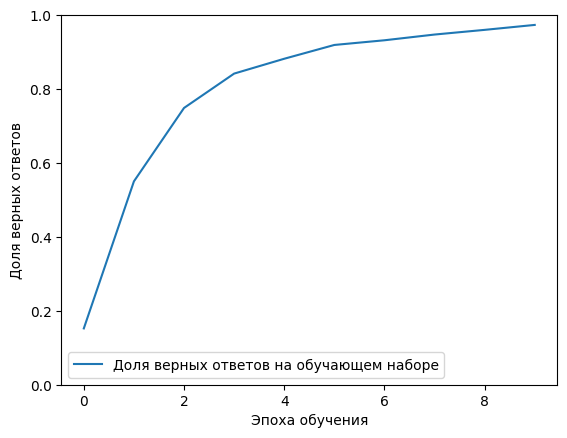

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'],
         label='Training Accuracy')
# plt.plot(history.history['val_categorical_accuracy'],
#          label='Validation Accuracy')
plt.ylim([0, 1])
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test on new data

In [ ]:
# test_images = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    label_mode='categorical',
    class_names=class_labels,
    image_size=(IMG_SIZE,IMG_SIZE)
)
test_images, test_labels = next(test_ds)
# test_labels = test_ds.labels
# test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

predictions = model.predict(test_images)

In [ ]:
test_images.labels

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
      color = 'blue'
  else:
      color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                              100*np.max(predictions_array),
                              class_labels[true_label]),
                              color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

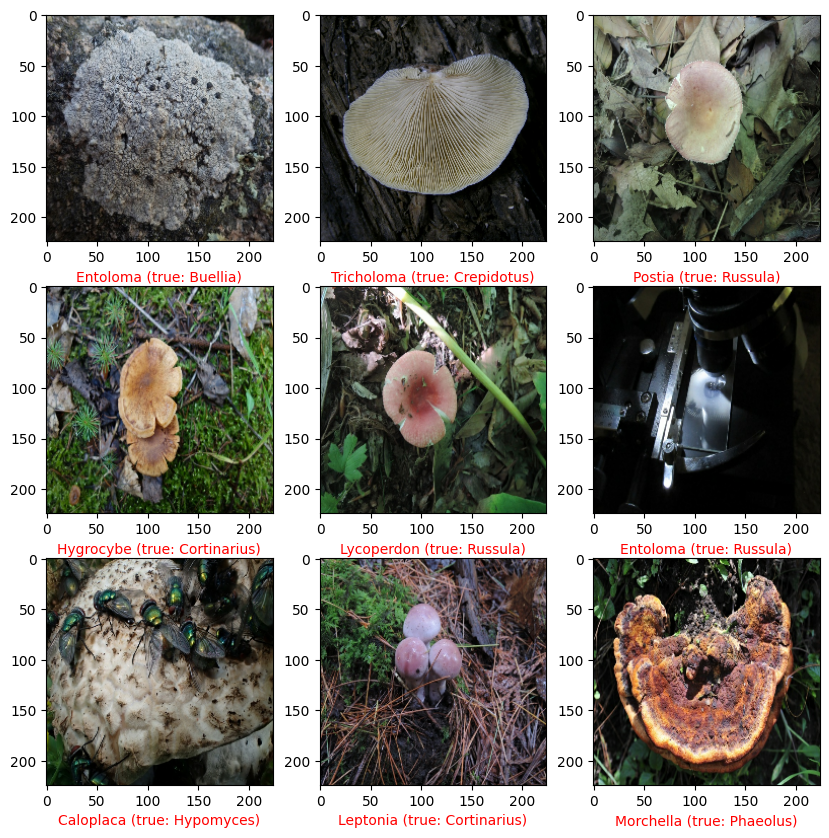

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_images.take(1):
    for i in range(9):
        # predicted_label = np.argmax(predictions[i])
        score = tf.nn.softmax(predictions[i])

        ax = plt.subplot(3, 3, i + 1)
        
        predicted_label = test_labels[np.argmax(predictions[i])]


        plt.imshow(images[i].numpy().astype("uint8"))

        # plt.title(true_label)
        plt.xlabel(f"{predicted_label}")
        # plt.axis("off")
        # plt.xlabel(
        #     "{} {:2.0f}% ({})".format(predicted_label, 100*np.max(predictions), true_label),
        #     color=color
        # )

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_images)

20/20 [==============================] - 18s 864ms/step


In [ ]:
len(test_labels)

543

In [ ]:
len(class_labels)

543

In [ ]:
len(predictions)

609

In [ ]:
cm = confusion_matrix(test_labels, predictions, labels=class_labels)

print('CONFUSION MATRIX\n', cm, '\n\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels)
disp.plot()

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [543, 609]

In [ ]:
PATH = "data_test/Agaricus/210751.jpg"
print(f"Prediction for {PATH}...")
img = tf.keras.utils.load_img(
    PATH, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_labels[np.argmax(score)], 100 * np.max(score))
)

predicted_class = class_labels[np.argmax(score)]
# predicted_class = class_labels[predicted_index]

if predicted_class in mushroom['genus'].values:
    edibility = mushroom.loc[mushroom['genus'] == predicted_class, 'label'].iloc[0]
else:
    edibility = "Unknown"

plt.imshow(img)
plt.axis('off')
# Output the result
print(f"Predicted class: {predicted_class}")
print(f"Edibility: {edibility}")

Prediction for data_test/Agaricus/210751.jpg...


NameError: name 'tf' is not defined

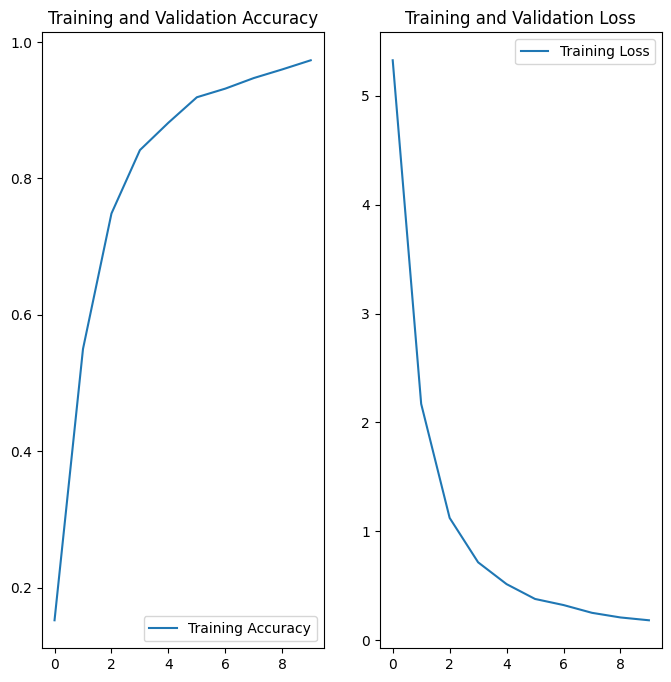

In [ ]:
acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs=10
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
image = Image.open('data_train/Amanita/217039.jpg').resize((224, 224))
image_array = np.array(image) / 255.0
image_tensor = tf.expand_dims(image_array, 0)

result = model.predict(image_tensor)

1/1 [==============================] - 1s 1s/step


In [ ]:
np.argmax(result)

329

In [ ]:
image_array = np.array(image) / 255.0
image_tensor = tf.expand_dims(image_array, 0)

# Predict with the model (same as before)
predictions = model.predict(image_tensor)
predicted_index = np.argmax(predictions[0])
# predicted_index = np.argmax(predictions)

Predicted class: Amanita
Edibility: Edible


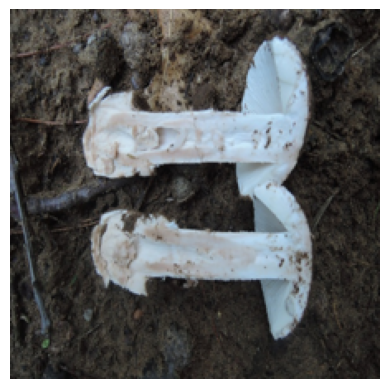

In [21]:
if predicted_class in mushroom['genus'].values:
    edibility = mushroom.loc[mushroom['genus'] == predicted_class, 'label'].iloc[0]
else:
    edibility = "Unknown"

plt.imshow(image)
plt.axis('off')
# Output the result
print(f"Predicted class: {predicted_class}")
print(f"Edibility: {edibility}")

In [22]:
%store predicted_class

Stored 'predicted_class' (str)
